In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from numba import njit

In [2]:
df = pd.read_pickle('btcusdt_grid')

In [3]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'best_bid', 'best_ask'], dtype='object')

In [4]:
@njit
def predict_njit(fee_, half_spread, price_range, order_interval, max_position, X):
    tick_size = 0.1
    running_qty = 0
    static_equity = 0
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 0
    high = 1
    low = 2
    close = 3
    volume = 4
    best_bid = 5
    best_ask = 6
    tick_ub = 100000
    dollar_qty = 10
    interval_tick = int(round(order_interval / tick_size))
    lb_price = 0
    ub_price = tick_ub - 1
    
    min_bid_order_tick = 0
    max_bid_order_tick = 0
    min_ask_order_tick = tick_ub - 1
    max_ask_order_tick = tick_ub - 1
    
    for row in X:
        best_bid_tick = int(round(row[best_bid] / tick_size))
        best_ask_tick = int(round(row[best_ask] / tick_size))
        # Check if bid orders are filled.
        for tick in range(max_bid_order_tick, min_bid_order_tick, -1):
            bid_price_tick = tick * interval_tick
            bid_price = bid_price_tick * tick_size
            if not np.isnan(row[low]):
                low_tick = int(round(row[low] / tick_size))
                if low_tick < bid_price_tick:
                    order_qty = dollar_qty / bid_price
                    running_qty += order_qty
                    static_equity -= bid_price * order_qty
                    fee += bid_price * order_qty * fee_
        # Check if ask orders are filled.
        for tick in range(min_ask_order_tick, max_ask_order_tick, 1):
            ask_price_tick = tick * interval_tick
            ask_price = ask_price_tick * tick_size
            if not np.isnan(row[high]):
                high_tick = int(round(row[high] / tick_size))
                if high_tick > ask_price_tick:
                    order_qty = dollar_qty / ask_price
                    running_qty -= order_qty
                    static_equity += ask_price * order_qty
                    fee += ask_price * order_qty * fee_
                
        mid = .5 * (row[best_bid] + row[best_ask])
        equity.append(static_equity + running_qty * mid - fee)
        running_qty_.append(running_qty)
        x = running_qty * mid / max_position # in $
        
        # Every second calculate grid order prices again. It doesn't need to cancel all and place all again live.
        bid_order_begin = min(mid - half_spread, row[best_bid])
        ask_order_begin = max(mid + half_spread, row[best_ask])
        lb_price = mid - price_range
        ub_price = mid + price_range

        if x <= 1:
            max_bid_order_tick = int(round(bid_order_begin / tick_size))
            max_bid_order_tick = int(np.floor(max_bid_order_tick / interval_tick))
            min_bid_order_tick = int(np.floor(lb_price / tick_size / interval_tick))
        else:
            # Cancel all bid orders if the position exceeds the maximum position.
            min_bid_order_tick = max_bid_order_tick = 0
        if x >= -1:
            min_ask_order_tick = int(round(ask_order_begin / tick_size))
            min_ask_order_tick = int(np.ceil(min_ask_order_tick / interval_tick))
            max_ask_order_tick = int(np.ceil(ub_price / tick_size / interval_tick))
        else:
            # Cancel all ask orders if the position exceeds the maximum position.
            min_ask_order_tick = max_ask_order_tick = tick_ub - 1
    return equity, running_qty_

class Backtest:
    def __init__(self, fee=None, max_position=None, half_spread=None, price_range=None, order_interval=None):
        self.fee = fee
        self.max_position = max_position
        self.price_range = price_range
        self.order_interval = order_interval
        self.half_spread = half_spread
        
    def set_params(self, half_spread, price_range, order_interval):
        self.price_range = price_range
        self.order_interval = order_interval
        self.half_spread = half_spread
        return self
        
    def get_params(self, deep=True):
        return { 'fee': self.fee, 'max_position': self.max_position, 'order_interval': self.order_interval, 'price_range': self.price_range, 'half_spread': self.half_spread }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        equity, running_qty = predict_njit(self.fee, self.half_spread, self.price_range, self.order_interval, self.max_position, X)
        return equity, running_qty
    
    def score(self, X):
        equity, _ = self.predict(X)
        returns = (pd.Series(equity).diff() / self.max_position).fillna(0)
        return np.divide(returns.mean(), returns.std())

In [5]:
param_dist = { 'price_range': stats.uniform(10, 500), 'order_interval': stats.uniform(10, 50), 'half_spread': stats.uniform(0.1, 10) }
# This backtest assumes that you can earn rebates(0.003%) by participating Binance's liquidity provider program.
# https://www.binance.com/en/support/announcement/9ad4e7c30713433f9ebd355567f0d60c
search = RandomizedSearchCV(Backtest(-0.00003, 1000),
                            cv=[(np.arange(len(df)), np.arange(len(df)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=100,
                            n_jobs=1)
#search.fit(df.values)

In [6]:
search.best_estimator_ = Backtest(-0.00003, 1000)

In [7]:
best_params_ = {
    'half_spread': 3.7517838107128654,
    'order_interval': 20.096339256735745,
    'price_range': 301.52574415851782
}
search.best_estimator_.set_params(**best_params_)

In [8]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)

<AxesSubplot:>

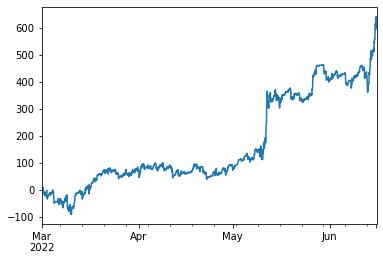

In [9]:
equity.iloc[::3600].plot()

<AxesSubplot:>

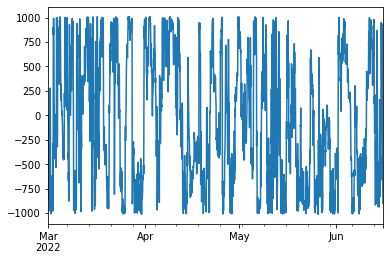

In [10]:
(running_qty * df['close']).iloc[::3600].plot()

In [11]:
df = pd.read_pickle('btcusdt_grid100') # 100ms interval

In [12]:
train = df[df.index < '2022-5-1']
valid = df[df.index >= '2022-5-1']

In [13]:
param_dist = { 'price_range': stats.uniform(10, 500), 'order_interval': stats.uniform(1, 50), 'half_spread': stats.uniform(0.1, 10) }
# This backtest assumes that you can earn rebates(0.003%) by participating Binance's liquidity provider program.
# https://www.binance.com/en/support/announcement/9ad4e7c30713433f9ebd355567f0d60c
search = RandomizedSearchCV(Backtest(-0.00003, 1000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=100,
                            n_jobs=1)
#search.fit(train.values)

In [14]:
search.best_estimator_ = Backtest(-0.00003, 1000)

In [15]:
best_params_ = {
    'half_spread': 3.588029293964708,
    'order_interval': 5.583739968678803,
    'price_range': 158.10344098886486
}
search.best_estimator_.set_params(**best_params_)

In [16]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:>

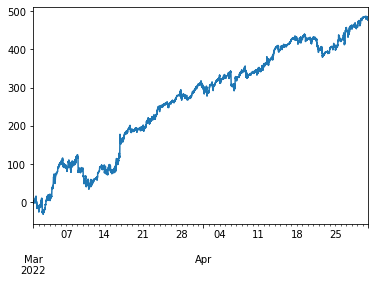

In [17]:
equity.iloc[::3600].plot()

<AxesSubplot:>

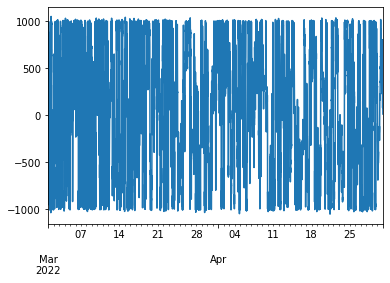

In [18]:
(running_qty * train['close']).iloc[::3600].plot()

Start date                         2022-03-01
End date                           2022-06-15
Time period (days)                        106
Train period          2022-03-01 - 2022-04-30
Valid period          2022-05-01 - 2022-06-15
Sharpe ratio                              9.1
Annualised return                        443%
RRR                                     48.04
MDD                                     9.23%
Max Position                            $1000
ADTV                                  $162131
dtype: object


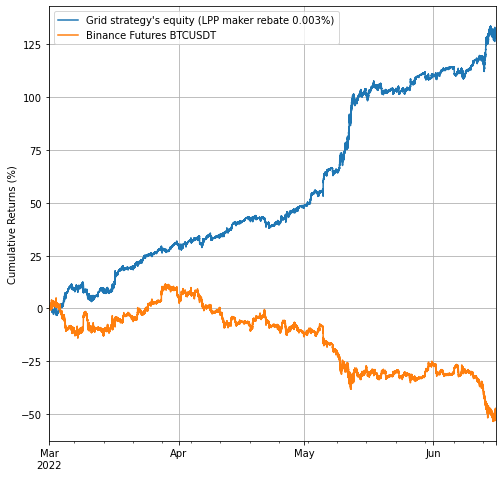

In [19]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)

returns = equity.resample('1d').last().diff() / search.best_estimator_.max_position
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(365)
trade_volume =  (running_qty * df['close']).diff().abs().rolling(24 * 3600 * 10, min_periods=1).sum().mean()

# equity_1d = equity.resample('1d').last()
Roll_Max = equity.cummax()
Drawdown = (equity - Roll_Max) / search.best_estimator_.max_position
Max_Drawdown = Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': '%.1f' % sr,
    'Annualised return': '%d%%' % (equity[-1] / search.best_estimator_.max_position / period * 365 * 100),
    'RRR': '%.2f' % (equity[-1] / search.best_estimator_.max_position / period * 365 / abs(Max_Drawdown.min())),
    'MDD': '%.2f%%' % (-Max_Drawdown.min() * 100),
    'Max Position': '$%d' % search.best_estimator_.max_position,
    'ADTV': '$%d' % trade_volume,
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = (equity / search.best_estimator_.max_position * 100)[::60].plot()
# ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100)[::60].plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Grid strategy's equity (LPP maker rebate 0.003%)", 'Binance Futures BTCUSDT'])
ax1.grid()